# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# [1]. Reading Data

# Applying Multinomial Naive Bayes

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Mounting Google Drive locally

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect("/content/gdrive/My Drive/Dataset/database.sqlite")



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(87773, 10)

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:38<00:00, 2283.46it/s]


In [0]:
final["CleanText"] = [preprocessed_reviews[i] for i in range(len(final))]

# [4] Featurization

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score
import seaborn as sns

from sklearn.metrics import confusion_matrix


In [0]:
Total_X = final['CleanText'].values
Total_y = final['Score'].values

In [0]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(Total_X, Total_y, test_size=0.33)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 


In [0]:
print(f"Train Data : ({len(X_train)} , {len(y_train)})")
print(f"CV Data : ({len(X_cv)} , {len(y_cv)})")
print(f"Test Data : ({len(X_test)} , {len( y_test)})")

Train Data : (39400 , 39400)
CV Data : (19407 , 19407)
Test Data : (28966 , 28966)


## [4.1] BAG OF WORDS

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[1000:1010])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)


print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

some feature names  ['amanzon', 'amaon', 'amaranth', 'amarena', 'amaretto', 'amarillo', 'amart', 'amason', 'amassed', 'amateur']
After vectorizations
(39400, 37474) (39400,)
(19407, 37474) (19407,)
(28966, 37474) (28966,)


100%|██████████| 15/15 [00:01<00:00, 13.98it/s]



The 'α' value 0.5 with highest roc_auc Score is 81.59363978925767 %


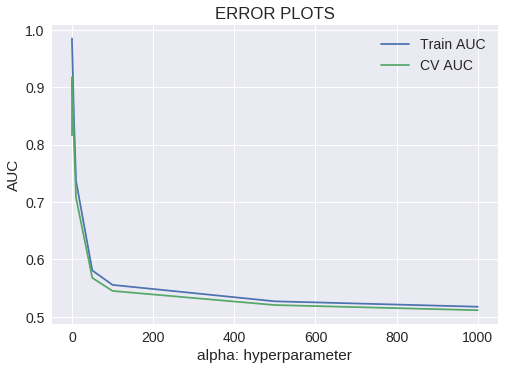

In [0]:

   
train_auc = []
cv_auc = []
max_α=0
max_roc_auc=-1
all_alpha = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
for i in tqdm(all_alpha):
    
    clf = MultinomialNB(alpha= i)
    clf.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  clf.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  clf.predict_proba(X_cv_bow)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_α=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'α' value {max_α} with highest roc_auc Score is {proba2} %" ) 
plt.plot(all_alpha, train_auc, label='Train AUC')
plt.plot(all_alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

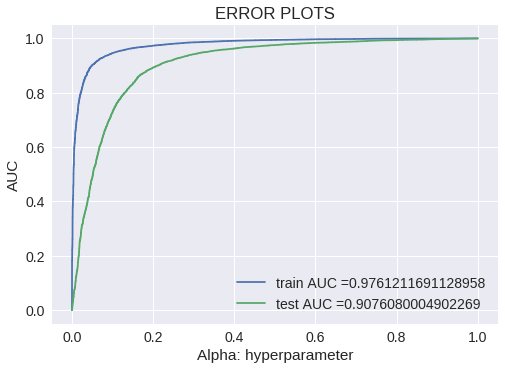

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


clf =  MultinomialNB(alpha= max_α)
clf.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Confusion Matrix of test set:
 [ [TN  FP]
   [FN TP] ]



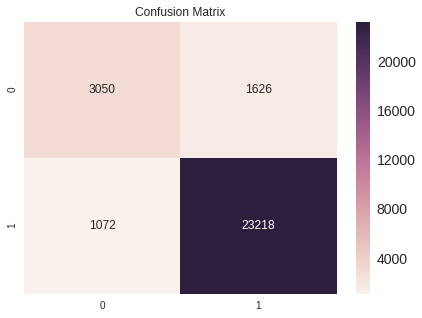

In [0]:
print("\nConfusion Matrix of test set:\n [ [TN  FP]\n   [FN TP] ]\n")
confusionMatrix=confusion_matrix(y_test, clf.predict(X_test_bow))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")


### [5.1.1] Top 10 important features of positive and negative class from<font color='red'> SET 1</font>

Reference : https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

In [0]:
def important_features(vectorizer,classifier,n=10):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_log_prob_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_log_prob_[1], feature_names),reverse=True)[:n]
    print("Important words in ***Negative Reviews***")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print("-----------------------------------------")
    print("Important words in ***Positive Reviews***")
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat) 

    
important_features(count_vect,clf)

Important words in ***Negative Reviews***
0 -3.3289694634411084 not
0 -4.408435155177267 like
0 -4.688774398294561 would
0 -4.739626332304205 taste
0 -4.771912915100497 product
0 -4.9219871132445485 one
0 -5.189708133055455 coffee
0 -5.196498282601085 good
0 -5.226041600292339 no
0 -5.285172123519161 flavor
-----------------------------------------
Important words in ***Positive Reviews***
1 -3.729909754253555 not
1 -4.541381633388246 like
1 -4.675217517784812 good
1 -4.762495459822585 great
1 -4.886385738329892 one
1 -4.987296311244986 taste
1 -5.032653728058932 coffee
1 -5.084882704482354 would
1 -5.086750467445954 flavor
1 -5.0881223808564435 love


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)


print("After vectorizations")
print(X_train_tf_idf.shape, y_train.shape)
print(X_cv_tf_idf.shape, y_cv.shape)
print(X_test_tf_idf.shape, y_test.shape)
print("="*100)

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get', 'able give']
After vectorizations
(39400, 23432) (39400,)
(19407, 23432) (19407,)
(28966, 23432) (28966,)


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]



The 'α' value 0.1 with highest roc_auc Score is 92.08078360586316 %


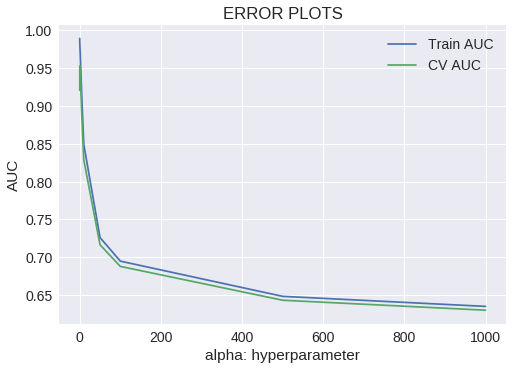

In [0]:
train_auc = []
cv_auc = []
max_α=0
max_roc_auc=-1
all_alpha = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
for i in tqdm(all_alpha):
    
    clf = MultinomialNB(alpha= i)
    clf.fit(X_train_tf_idf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  clf.predict_proba(X_train_tf_idf)[:,1]
    y_cv_pred =  clf.predict_proba(X_cv_tf_idf)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_α=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'α' value {max_α} with highest roc_auc Score is {proba2} %" ) 
plt.plot(all_alpha, train_auc, label='Train AUC')
plt.plot(all_alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

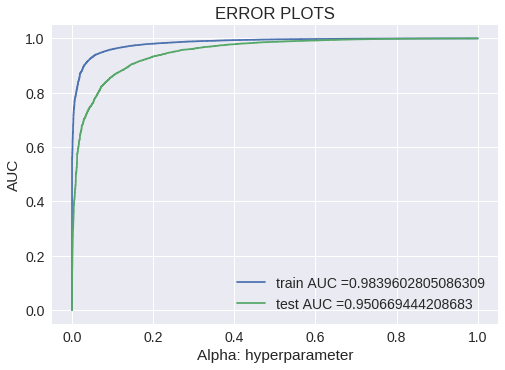

In [0]:

clf =  MultinomialNB(alpha= max_α)
clf.fit(X_train_tf_idf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_tf_idf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Confusion Matrix of test set:
 [ [TN  FP]
   [FN TP] ]



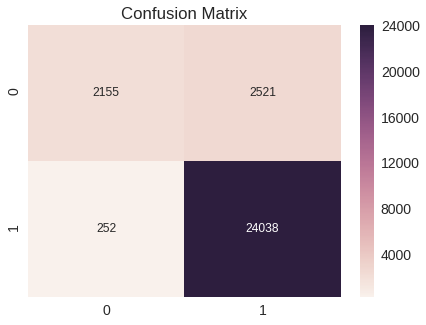

In [0]:
print("\nConfusion Matrix of test set:\n [ [TN  FP]\n   [FN TP] ]\n")
confusionMatrix=confusion_matrix(y_test, clf.predict(X_test_tf_idf))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")


### [5.2.2] Top 10 important features of Positive and Negative class from<font color='red'> SET 2</font>

In [0]:
important_features(tf_idf_vect,clf)

Important words in ***Negative Reviews***
0 -4.688348528399779 not
0 -5.4884646971089985 like
0 -5.606129345264658 product
0 -5.6218927676473305 would
0 -5.6361638685814714 taste
0 -5.872510391942559 coffee
0 -5.936074955390046 one
0 -6.083180357129672 no
0 -6.129491526883766 flavor
0 -6.18855503805009 food
-----------------------------------------
Important words in ***Positive Reviews***
1 -5.223920619254398 not
1 -5.570975110103897 great
1 -5.632781802191627 good
1 -5.68406211681225 like
1 -5.73462454052433 coffee
1 -5.799326807423803 love
1 -5.8216313550165335 tea
1 -5.911882066936094 one
1 -5.935393127712199 taste
1 -5.942529751701102 product


# [6] Conclusions

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter(α)","Test AUC"]

x.add_row(["BoW","Multinomial Naive Bayes",0.5,0.90])
x.add_row(["Tf-Idf","Multinomial Naive Bayes", 0.1,0.95])

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('**Conclusion:**')
print(x)

**Conclusion:**

+------------+-------------------------+--------------------+----------+
| Vectorizer |          Model          | Hyper parameter(α) | Test AUC |
+------------+-------------------------+--------------------+----------+
|    BoW     | Multinomial Naive Bayes |        0.5         |   0.9    |
|   Tf-Idf   | Multinomial Naive Bayes |        0.1         |   0.95   |
+------------+-------------------------+--------------------+----------+




*   **Test Prob.(unseen data) using Multinomial Naive Bayes:**

1.  BoW has predicted 90% accurate and Tf-idf has predicted 95% accurate on test data using Multinomial Naive Bayes.



